### This is a continued work of the project "*Recent Trend on Thermoelectric Research*". The works prior to this was done with Spark on Databricks, and the notebook can be found at `http://www.yufeil.com/tedatabricksnotebook.html`

The primary goal of this work is to further explore the academic publications on thermoelectric, and hopefully we can cluster the articles into several groups, which could give us some insights of thermoelectric studies.

**What to do**:
1. Perform Word2Vec, cluster the words
2. Use LDA for topic modeling
3. Build an item-based recommendation system

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#concurrency
import multiprocessing
#regex
import glob
import re
import nltk
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold

C:\Users\YL\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


<h3 style="color:darkred">First let's load the titlesInfo.csv</h3>

In [3]:
titlesDF = pd.read_csv('titlesInfo.csv', header=0, encoding='ISO-8859-1')

In [4]:
titlesDF.shape

(67952, 7)

In [5]:
titlesDF.dtypes

Unnamed: 0        int64
title            object
journal          object
cover_date       object
citedby_count     int64
isTheory           bool
compounds        object
dtype: object

 There are 67952 articles. They are the publications on thermoelectrics since 1997.
 The meaning of the columns are (disregard the "Unnamed" column):
 1. "*title*": the title of the article, *string*
 2. "*journal*": the journal that the article is published, *string*
 3. "*cover_date*": the date that the article is published, *date YYYY-MM-DD*
 4. "*citedby_count*": the number of other articles that cite this one, *integer*
 5. "*isTheory*": whether this article is a purely theoretical paper, rather than an experimental one, *boolean*
 6. "*compounds*": what chemical compounds/elements are involved in the article, *string*, expressed as A,B,C

The values of the first four columns were extracted from the raw data retrieved from Elsevier API. For the last two columns, *isTheory* was determined based on a keyword search, while *compounds* were extracted using regex. These were done with Spark on Databricks, and the details could be found at `http://www.yufeil.com/tedatabricksnotebook.html`

In [6]:
# Fill the missing data in the titles and compounds with emtpy string.
titlesDF['title'].fillna('', inplace=True)
titlesDF['compounds'].fillna('', inplace=True)

titlesDF.head()

,Unnamed: 0,title,journal,cover_date,citedby_count,isTheory,compounds
0,0,Charge transfer behavior of erbium substituted...,Materials Chemistry and Physics,2003-07-20,10,False,"Mg,Ti"
1,1,Cooper Pair Splitting Efficiency in the Hybrid...,Journal of Superconductivity and Novel Magnetism,2017-01-01,1,False,
2,2,Superconducting and elastic properties of (Dy1...,Current Applied Physics,2003-10-01,1,False,"Dy1-xPrx,BaSrCu3O7-"
3,3,Optoelectronic engineering of colloidal quantu...,Proceedings of SPIE - The International Societ...,2017-01-01,0,False,
4,4,"Doping, co-doping, and defect effects on the p...",Proceedings of SPIE - The International Societ...,2017-01-01,0,False,ZnO


To analyze the titles, we first want to remove all compositions (1, 1.5, x, 1-x, etc.) in the molecular formulas. So *AxB1-xC* becomes *ABC*.

In [7]:
def remove_composition(row):
    compounds = row['compounds'].split(',')
    title_origin = row['title']
    if compounds:
        for compound in compounds:
            new_compound = re.sub(r'[\dxyz\.?\-]', '', compound)
            title_origin = title_origin.replace(compound, new_compound)
    return title_origin

In [8]:
titlesDF['cleaned_title'] = titlesDF.apply(remove_composition, axis=1)

In [9]:
# Check if it works
print('Original title: '+titlesDF.loc[101,'title'])
print('Cleaned title: '+titlesDF.loc[101,'cleaned_title'])

Original title: Potential Fluctuations at Low Temperatures in Mesoscopic-Scale SmTiO3/SrTiO3/SmTiO3 Quantum Well Structures
Cleaned title: Potential Fluctuations at Low Temperatures in Mesoscopic-Scale SmTiO/SrTiO/SmTiO Quantum Well Structures


### Let's first save the titles, and concatenate all titles into one string. The titles are separated by period symbols.

In [10]:
corpus_raw = u""
with open('titles.txt', 'a', encoding='utf-8') as f:
    for i in range(titlesDF.shape[0]):
        line = titlesDF.loc[i, 'cleaned_title']
        corpus_raw += line + '. '
        f.write(line + '\n')

In [11]:
len(corpus_raw)

6197019

In [12]:
corpus_raw[:500]

'Charge transfer behavior of erbium substituted Mg-Ti ferrites. Cooper Pair Splitting Efficiency in the Hybrid Three-Terminal Quantum Dot. Superconducting and elastic properties of (DPr)BaSrCuO?. Optoelectronic engineering of colloidal quantum-dot solar cells beyond the efficiency black hole: A modeling approach. Doping, co-doping, and defect effects on the plasmonic activity of ZnO-based transparent conductive oxides. Theoretical investigation on thermoelectric properties of Cu-based chalcopyrit'

<h3 style="color:darkred">Now let's start the analysis</h3>

### Preprocessing

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [14]:
# Tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [15]:
# Convert string to words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z0-9]", " ", raw)
    words = clean.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w)>3]
    if len(words) > 0:
        words[0] = words[0].lower() # Here we only make the first word to lower case, to avoid lower_case the molecular formulae.
        
    return words

In [16]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        s = sentence_to_wordlist(raw_sentence)
        if s:
            sentences.append(s)

In [17]:
len(sentences)

68946

In [18]:
token_count = sum([len(sentence) for sentence in sentences])
print(token_count)

568406


There are totally 68946 sentences/titles, and ~568k words.

Let's implement bigram, so that phrases such as charge_transfer, quantum_dot can be captured.

In [19]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

phrases = Phrases(sentences)
bigram = Phraser(phrases)

In [20]:
import pickle
pickle.dump(bigram, open("bigram.p", "wb"))

In [21]:
sentences_bigram = list(bigram[sentences])

In [86]:
sentences_bigram[:5]

[['charge_transfer', 'behavior', 'erbium', 'substituted_ferrite'],
 ['cooper',
  'Pair',
  'Splitting',
  'Efficiency',
  'Hybrid',
  'Three',
  'Terminal',
  'Quantum'],
 ['superconducting', 'elastic', 'property', 'BaSrCuO'],
 ['optoelectronic',
  'engineering',
  'colloidal',
  'quantum',
  'solar_cell',
  'beyond',
  'efficiency',
  'black_hole',
  'modeling',
  'approach'],
 ['doping',
  'doping',
  'defect',
  'effect',
  'plasmonic',
  'activity',
  'based',
  'transparent_conductive',
  'oxide']]

### Word2Vec

In this section, we will perform Word2Vec to the titles we have. It is a model introduced by Google at 2013. A good tutorial can be found at https://www.youtube.com/watch?v=ERibwqs9p38 and https://www.youtube.com/watch?v=pY9EwZ02sXU. Basically, we'd like to project every word to a higher dimensional space. The dimensionality used here is 300.

Here is several pictures that illustrate Word2Vec (from Tensorflow).

<img src='https://www.tensorflow.org/images/linear-relationships.png'>

The package we use here is gensim.

Parameters definition:

In [23]:
# Dimensionality of the word vectors
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for RNG
seed = 1

In [24]:
# Use gensim Word2Vec model
titles2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [25]:
titles2vec.build_vocab(sentences_bigram)

In [26]:
len(titles2vec.wv.vocab)

13264

Train the sentences

In [27]:
titles2vec.train(sentences_bigram, total_examples=titles2vec.corpus_count, epochs=titles2vec.iter)

2109745

In [28]:
# Save the model
titles2vec.save("titles2vec.w2v")

### Let's explore the model we trained.

In [29]:
titles2vec = w2v.Word2Vec.load("titles2vec.w2v")

In this model, each word in the vocabulary is represented by a 300 dimensional (recall that we defined *num_features = 300*) vector. To visualize it, we can reduce the vector space to 2-dimensional. The dimension reduction method we use here is *t stochastic neighbor embedding* 

In [31]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = titles2vec.wv.syn0

# Train t-SNE
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

Plot!

In [32]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[titles2vec.wv.vocab[word].index])
            for word in titles2vec.wv.vocab
        ]
    ],
    columns = ["word", "x", "y"]
)

In [33]:
points.head(10)

,word,x,y
0,charge_transfer,30.231714,-41.645325
1,behavior,42.043770,-48.202106
2,erbium,24.321648,-41.394527
3,substituted_ferrite,39.869400,-49.869637
4,cooper,37.804096,9.120140
5,Pair,-9.194844,49.261890
6,Splitting,-29.956104,67.045944
7,Efficiency,-48.102470,86.562569
8,Hybrid,-43.482807,92.065010
9,Three,-46.394089,75.454796


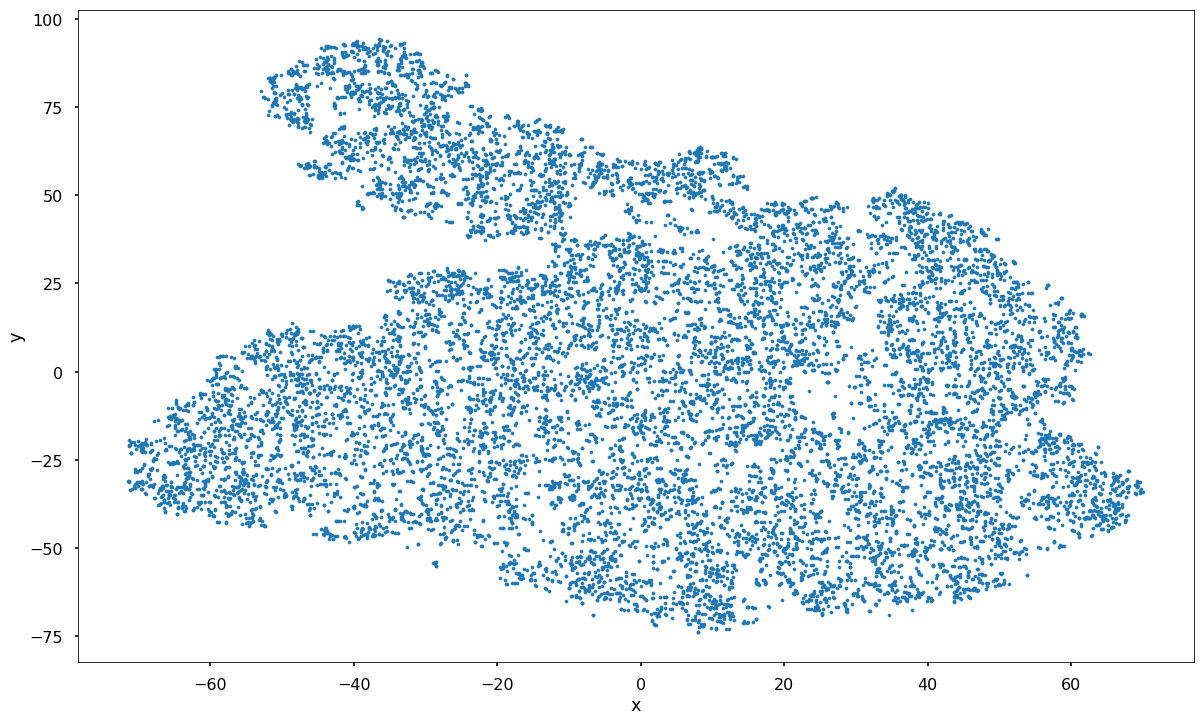

In [34]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

The plot shows the 2D representation of all words in the vocabulary. Here the closer two words are, the more similar they are. Let's zoom in to see some interesting regions.

In [35]:
# Plot zoomed regions
def plot_region(x_bounds, y_bounds):
    #print(points.shape)
    s = points[ (points['x'] >= x_bounds[0]) & (points['x'] <= x_bounds[1])] 
    #print(s.shape)
    s = s[(s['y'] >= y_bounds[0]) & (s['y'] <= y_bounds[1])]
    #print(s.shape)
    #print(s.head())
    ax = s.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in s.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [36]:
# Give a query word, plot the words nearby
def plot_nearby(word,side_len=4):
    if side_len <= 0:
        print('side_len should be greater than zero!')
        return
    try:
        coordinates = points[points['word']==word].reset_index()
        x, y = coordinates.loc[0,'x'], coordinates.loc[0,'y']
        x1, x2, y1, y2 = x-side_len/2, x+side_len/2, y-side_len/2, y+side_len/2
        plot_region(x_bounds=(x1,x2), y_bounds=(y1,y2))
    except Exception as e:
        print('---------------------Cannot find {} in the vocabulary----------------'.format(word))

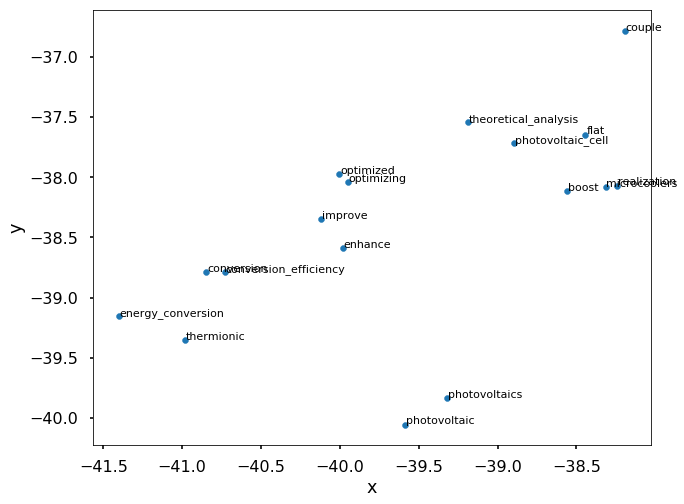

In [65]:
plot_nearby('enhance',4)

The words in this region are indeed related to *enhance*.

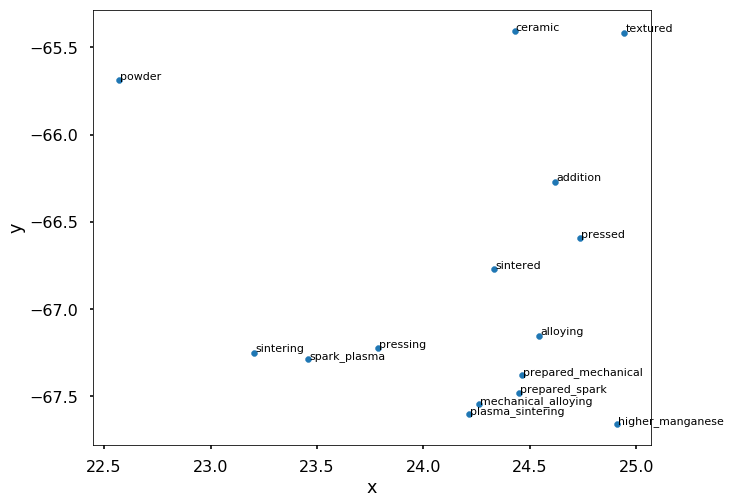

In [38]:
plot_nearby('sintering',4)

This plot is about different sintering techniques.

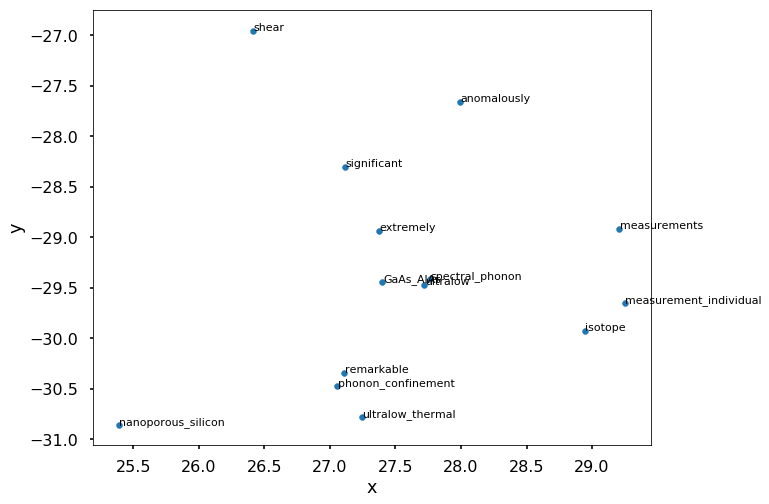

In [83]:
plot_nearby('extremely',4)

The words in this region are close to "*extremely*".

#### Semantic similarities between some words

We can also display the similar words to the query word

In [40]:
titles2vec.most_similar('sintering')

[('spark_plasma', 0.9458023905754089),
 ('pressing', 0.907372236251831),
 ('sintered', 0.8860670924186707),
 ('powder', 0.8843217492103577),
 ('sintering_process', 0.8781840801239014),
 ('densification', 0.8762843608856201),
 ('consolidation', 0.8668695688247681),
 ('melt_spinning', 0.8609418869018555),
 ('milling', 0.8588725924491882),
 ('pulse_current', 0.8549903631210327)]

Spark plasma sintering is a popular technique in thermoelectric research. It densifies powder into a pellet via applying pressure at both side. So this list makes sense.

<h3 style="color:darkred">Next, we perform topic modeling. We adopt (Latent Dirichlet Allocation) LDA model using Gensim. </h3>

In [41]:
from gensim.corpora import Dictionary

dictionary = Dictionary(sentences_bigram)

In [42]:
corpus = [dictionary.doc2bow(sentence) for sentence in sentences_bigram]

In [43]:
corpus[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 1), (13, 1), (14, 1), (15, 1)],
 [(16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1)],
 [(26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]

Each element in the "corpus" list corresponds to a title, and what words of the *dictionary* it contains.

In [44]:
from gensim.models import LdaModel

In [46]:
# Picking the number of topics is tricky. Here we set it to three.
ldamodel = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary)
ldamodel.show_topics()

[(0,
  '0.024*"system" + 0.017*"power" + 0.014*"thermal" + 0.013*"analysis" + 0.010*"based" + 0.009*"performance" + 0.009*"energy" + 0.009*"using" + 0.008*"power_plant" + 0.008*"application"'),
 (1,
  '0.062*"property" + 0.060*"thermoelectric" + 0.012*"material" + 0.011*"synthesis" + 0.010*"effect" + 0.010*"electrical" + 0.010*"type" + 0.009*"alloy" + 0.009*"transport" + 0.009*"doped"'),
 (2,
  '0.017*"thin_film" + 0.016*"effect" + 0.011*"transport" + 0.009*"structural" + 0.008*"property" + 0.008*"optical" + 0.008*"study" + 0.008*"film" + 0.008*"temperature" + 0.007*"electronic"')]

Let's visualize it!

In [47]:
import pyLDAvis
import pyLDAvis.gensim
lda_vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_vis)

C:\Users\YL\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


It seems like the titles could be classified into 3 topics: 

(1) Focuses on thermoelectric materials application, including words like *high*, *performance*, *power*;

(2) Fundamental thermoelectric properties study, with words like *property*, *electrical*, *magnetic*, *study*, etc.

(3) Also on the application of thermoelectrics, but more industry oriented, such as *power_plant*, *combustion*, and *solar_cell*.

#### Building a model to generate new titles.

With the titles2vec model, we can implement a function to automatically generate a new title, based on the old one.

In [61]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_title(title, stop_words=stop_words):
    # To do: convert molecular formula
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Exception as e:
        pass
    words = ' '.join(words)
    words = bigram[words.split()]
    return " ".join([w for w in words if w not in stop_words and w not in r':-.,'])

def find_nearest(word, model=titles2vec, k=3):
    # Find k nearest neighbors and return a random one.
    # Later to optimize it we will first PCA to lower dimentionality.
    if word not in model.wv.vocab:
        return word
    from random import choice
    candidates = [w for w,x in model.most_similar(word)]
    candidates += [word]
    return choice(candidates)
    

def generate_new_title(title,stop_words=stop_words,k=3):
    original_words = title.split()
    
    new_words = []
    for word in original_words:
        if word.lower() in stop_words:
            new_words.append(word)
            continue
            
        new_word = find_nearest(word,k=k)
        new_words.append(new_word)
    
    return " ".join(new_words)

In [49]:
generate_new_title("The review of thermoelectric")

'The advanced of thermoelectrical'

In [50]:
generate_new_title("Recent progress on enhancing electrical resistivity")

'Issues nanotechnology on dimensionless_figure thermoelectrical specific_heat'

In [51]:
generate_new_title("Effect of doping on thermal conductivity")

'Enhanced of substitution on heat scattering'

Some of them make some sense, and some are like gibberish. To achieve a better model, we need 

(1) larger corpus 

(2) hyper-parameter tuning

(3) implementation of phrase chunking, stemming, etc.

<h3 style="color:darkred">Building an item-based recommendation system</h3>

We can build an item-based recommendation system for the articles, based on the similarity between titles. In the future I'll also try to implement a more complex recommendation system, where the authors are considered as users, and articles are items.

First let's figure out a way to calculate how similar two articles are.

We can treat the titles as bag-of-words, and since we already projected each word to a 300 dimensional space, we can simply take the sum of them, and represent each title as a 300-dimensional vector.

In [62]:
# Convert title to vector
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def title_to_vec(title, model=titles2vec, dim=300, stop_words=stop_words):
    result = np.zeros(dim)
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Exception as e:
        pass
    words = ' '.join(words)
    words = bigram[words.split()]
    words = [w for w in words if w not in stop_words and w not in r':-.,']
    
    for word in words:
        if word in model.wv.vocab:
            w2v = model.wv[word]
            result += w2v
    
    return result

With the function above, we can convert titles to vectors

In [53]:
titlesDF['title_vec'] = titlesDF['cleaned_title'].apply(lambda x: title_to_vec(x, titles2vec))

In [54]:
titlesDF['title_vec'][:5]

0    [-0.102761008311, 0.135368030518, 0.5147146494...
1    [-0.497117865831, 0.84870994091, 0.42439445853...
2    [-0.0416589193046, 0.0426737591624, 0.63566005...
3    [-0.359500570223, 1.2083757259, -0.16656915471...
4    [-0.357993676444, 0.188759524375, 0.6039085034...
Name: title_vec, dtype: object

Now each title is associated with a 300d vector. So given any new title, we can calculate the most similar titles to it. Here we use *cosine similarity*.

In [55]:
def cos_sim(v1, v2):
    """ Returns a custmized cosine similarity of two vectors"""
    norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
    norm_product = norm1 * norm2
    if norm_product == 0:
        return 0
    
    # It is found that the vallina cosine similarity doesn't do
    # a good job, partially due to the fact that it ignores the
    # difference between the lengths of the two vectors. Here I
    # try to add a pre-factor to the original cos_sim to repre-
    # sent the difference between two lengths.
    norm_ratio = min(norm1, norm2) / max(norm1, norm2)
    
    return np.dot(v1, v2) * np.sqrt(norm_ratio) / norm_product

In [63]:
def clean_title(title, stop_words=stop_words):
    # To do: convert molecular formula
    words = word_tokenize(title)
    try:
        words[0] = words[0].lower()
    except Exception as e:
        pass
    words = ' '.join(words)
    words = bigram[words.split()]
    return " ".join([w for w in words if w not in stop_words and w not in r':-.,'])

In [57]:
def get_most_similar_title(new_title, titlesDF, model, dim=300, k=1):
    """ Returns the k most similar titles to the new_title"""
    new_title = clean_title(new_title)
    new_vec = title_to_vec(new_title, model, dim)
    sim_list = titlesDF[titlesDF['title'] != '']['title_vec'].apply(lambda x: cos_sim(new_vec, x)).values
    
    # Plot distribution of cos_sim_list
    plt.hist(sim_list, bins=50)
    plt.xlabel('Similarity')
    plt.ylabel('Count')
    plt.title('Distribution of Similarities')
    plt.show()
    
    indices = find_topk_indices(sim_list, k)
    
    similar_titles = [titlesDF.loc[i, 'title'] for i in indices]
    
    print("Cleaned Title: " + new_title)
    print('Similar Articles:\n')
    for i, title in enumerate(similar_titles):
        print('('+str(i+1)+')  '+title+'\n')
    
    return similar_titles

def find_topk_indices(s, k):
    # Return the indices of the largest k elements, ordered by their values.
    from heapq import heappush, heappop
    res = []
    for i, n in enumerate(s):
        if not res or len(res) < k or res[0][0] < n:
            heappush(res, (n,i))
        if len(res) > k:
            heappop(res)
    return [i for n, i in sorted(res, reverse=True)]
            

The *get_most_similar_title* function returns a list of similar papers to the query paper.

#### I deployed the recommendation system model on Heroku http://paperflask.herokuapp.com/

Future works:
1. Optimize the word2vec model. Implement stemming and lemmatization
2. Further improve the recommendation system. For example, take authors into consideration.
3. Build a model to automatically generate titles
4. Analyze the network among authors